# 3D cell calling demo

This is a short demo on how to use the pciSeq_3D package.

## 1. The wheel

Install the package with the following command:

In [1]:
!pip install "https://storage.googleapis.com/dxn_temp/3D_data/demo_data/pciSeq_3D-0.0.5-py3-none-any.whl"

You can now import the pciSeq_3D package (and some other needed for this notebook)

In [2]:
import pciSeq_3D
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import skimage.io
import matplotlib.pyplot as plt
import os

PyDIPjavaio unavailable:
DLL load failed: The specified module could not be found.

libjvm not found
DIPlib -- a quantitative image analysis library
Version 3.2.0 (Feb  8 2022)
For more information see https://diplib.org


In [3]:
pciSeq_3D.__version__

'0.0.5'

## 2. The data

The required data are
 - Spots
 - Segmentation
 - Single cell data
 
 There is also a fourth optional argument to override the default hyperparameters set by [setup.py](https://github.com/acycliq/pciSeq/blob/dev_3d/pciSeq/config.py). To pass-in your own hyperparemeter values create a dict with keys the hyperparameter name and values the new values.
 
 Do not forget to set the pixel per micron (ppm) value so that it matches your experiment/imaging setup. The default value is ppm=6.0121. To override that with another value, let's say 3.5, make a dict opts = {'ppm': 3.5} and pass that dict as a fourth argument. 

### 2.1 The spots

Let's have a look at the spots. This should be a dataframe file with columns 'x', 'y', 'z_stack', 'Gene'. The ordering of the columns is not important, case-sensitivity however is.
Note also that while columns 'x' and 'y' are for actual spot coordinates, the one labelled as 'z_stack' keeps the frame number within the stacked 3D image on which the spot was detected. 

In [4]:
spots = pd.read_csv("https://storage.googleapis.com/dxn_temp/3D_data/demo_data/spots_yxz.csv")
spots.head()

,y,x,z_stack,Gene
0,5262.503247,4035.614339,17.788926,Nrn1
1,4279.503247,4037.614339,17.788926,Id2
2,5470.503247,4038.614339,17.788926,Cxcl14
3,5086.503247,4039.614339,17.788926,Cryab
4,4199.503247,4040.614339,17.788926,Neurod6


### 2.2 The segmentation

Segmentation should be provided as a list of coo_matrices. Basically, your segmentation tool should give you an array with dimensions Z-by-height-by-length. You can do something like label_image_list = [coo_matrix(d) for d in segmentation_array_3D] to get what is needed for the cell calling algothitm demo'ed here

In [5]:
label_image_url = "https://storage.googleapis.com/dxn_temp/3D_data/demo_data/label_image_3D.npy"
label_image_str = pciSeq_3D.utils.load_from_url(label_image_url)
label_image_list = np.load(label_image_str, allow_pickle=True)

Typically, it is often useful to go through and plot the segmentented frames of the 3D stack. We might spot cases where segmentation hasnt worked as  expected and we would probably choose to exclude those frames from the cell typing step

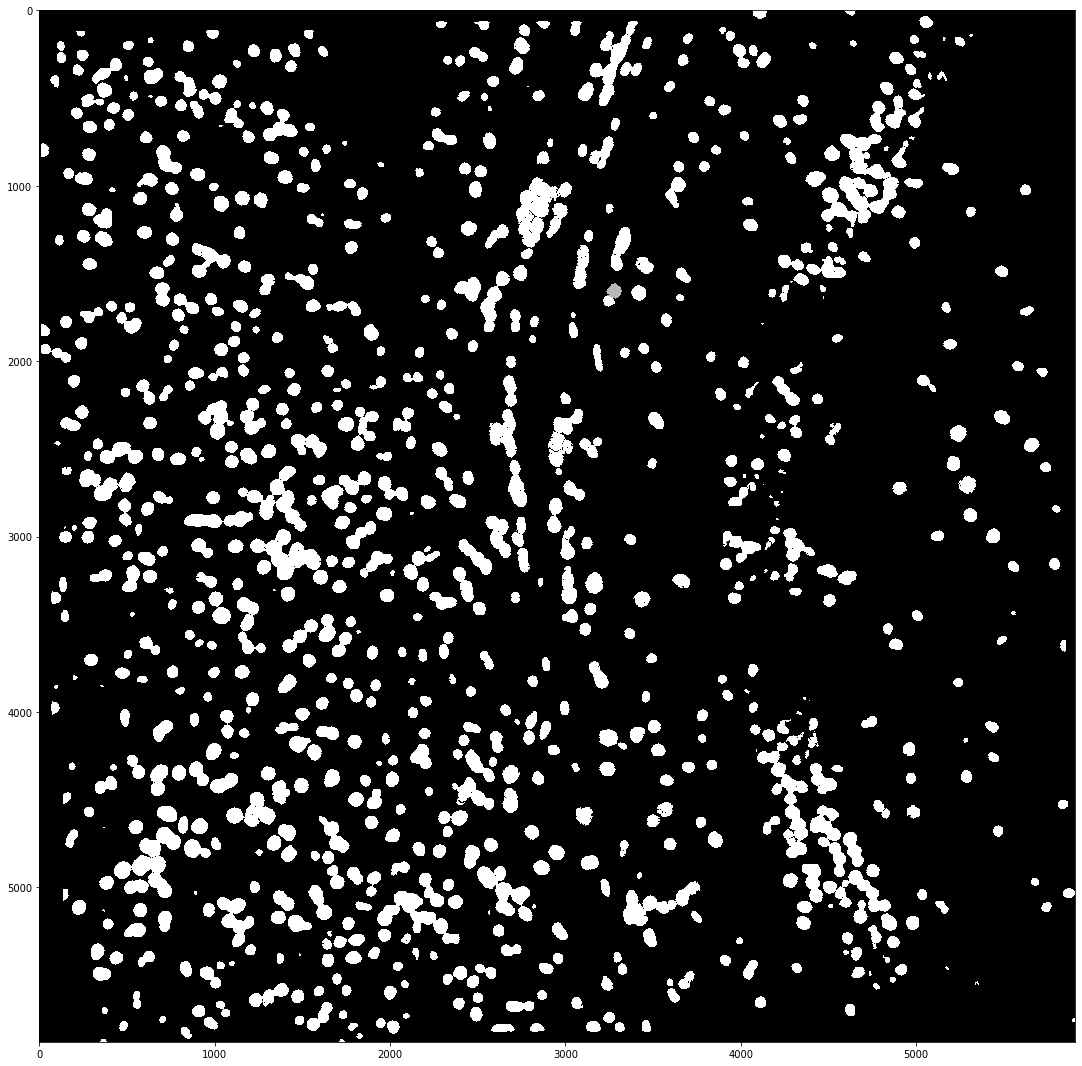

In [6]:
z_stack_num = 18
fig = plt.figure(figsize = (15,15))
skimage.io.imshow(label_image_list[z_stack_num].toarray(), cmap='gray', vmin = 0, vmax = 255, interpolation='none')

For example only the frames between 18 and 43 look to be well segmented. 
When we run the cell algorithm we can set the hyperparamers z_stack_min=18 and z_stack_max=43 to exclude the frames but also the spots too below frame 18 and above 43

### 2.3. The single cell data

This is another dataframe with columns the cell classes and rows the genes. The expression data are UMI counts as they come from single cell sequencing.

In [7]:
sc_file = pciSeq_3D.utils.load_from_url('https://storage.googleapis.com/dxn_temp/3D_data/demo_data/scRNAseq.csv.gz?raw=true')
scRNAseq = pd.read_csv(sc_file, header=None, index_col=0, compression='gzip', dtype=object)
scRNAseq = scRNAseq.rename(columns=scRNAseq.iloc[0], copy=False).iloc[1:]
scRNAseq = scRNAseq.astype(float).astype(np.uint32)

In [8]:
scRNAseq.head()

,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,...,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1
0,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Cell typing

We can now proceed with cell typing. Do not forget to pass-in the correct ppm setting (pixels per micron). In the example below, just for the sake of the demo, we pass-in the same value as the default one (6.0121). Also, from the 3D stacked image we choose to use the frames between (and including) 18 and 43 by setting z_stack_min and z_stack_max to the corresponding values. Note that behind the scenes, truncating the 3D image will also revove the spots associated with the deleted frames. 

To pass those user-defined settings make a dict:

In [9]:
opts = {
    'ppm': 6.0121,
    'z_stack_min': 18,
    'z_stack_max': 43,
    'CellCallTolerance': 0.5,
}

I have set the 'CellCallTolerance' hyperparameter to 0.5 only for demo purposes. That will cause the algorithm to achieve convergence prematurely but it will reduce execution time.
The default value is 0.02 which will make the algorithm run for too long for the scope of this notebook.

For cell typing run the fit() method as follows:

In [10]:
cellData, geneData = pciSeq_3D.fit(spots, label_image_list, scRNAseq=scRNAseq, opts=opts)

2022-05-18 15:48:17,414:INFO: ppm is set to 6.0121
2022-05-18 15:48:17,416:INFO: z_stack_min is set to 18
2022-05-18 15:48:17,417:INFO: z_stack_max is set to 43
2022-05-18 15:48:17,417:INFO: CellCallTolerance is set to 0.5
2022-05-18 15:48:17,418:INFO: Pixels per micron is set to: 6.012100
2022-05-18 15:48:17,419:INFO: Preprocessing data
2022-05-18 15:48:17,426:INFO: Truncating masks and spots. Keeping those between frame 18 and 43 only
2022-05-18 15:48:37,260:INFO: Found 3136 cells that exist on just one single frame. Those cells have been removed from 26 frames.
2022-05-18 15:49:24,780:INFO: Number of spots passed-in: 255058
2022-05-18 15:49:40,950:INFO: Number of segmented cells: 5712
2022-05-18 15:49:40,951:INFO: Segmentation array implies that image has width: 5905px and height: 5882px
2022-05-18 15:50:09,151:INFO: Single cell data passed-in have 27998 genes and 5712 cells
2022-05-18 15:50:09,152:INFO: Single cell data: Keeping counts for the gene panel of 73 only
2022-05-18 15:50

### 4. Reading the results
The results are two dataframes, cellData and geneData, each one keeping the output from the cell calling algorithm that is mainly relevant to the cells and the genes (spots) respectivelly

#### 4.1 The cellData
This dataframe keeps the coordinates of the cell centroid, the gene names of the spots assigned to each cell, with corresponding gene counts and class names with the associated posterior probabilities.
The cell centroid is expressed by the columns X, Y and Z. Note that all three are now in the same resolution which in this example is 6.0121 pixels per micron

In [11]:
cellData.head()

,Cell_Num,X,Y,Z,Genenames,CellGeneCount,ClassName,Prob,sphere_scale,sphere_rotation
1,1,3331.441173,1581.975643,157.699174,"[Cadps2, Calb2, Cnr1, Cryab, Cxcl14, Enpp2, Ga...","[0.0015752472885342827, 0.9559833882961797, 0....","[Astro.1, Astro.2, Calb2.Cntnap5a.Igfbp6, Calb...","[0.0019723480947494696, 0.0013239759711903046,...","[48.14365532834249, 47.20101422891103, 47.6298...","[1.5707963267948966, 0.0, -0.4247482155883045]"
2,2,193.480836,5091.382535,147.232357,"[Bcl11b, Cadps2, Cdh13, Cnr1, Cplx2, Cryab, Ga...","[0.20624663256959358, 0.2943856945656981, 0.01...","[Astro.1, Endo, Vsmc, Zero]","[0.0012654956537080358, 0.0034222787010953688,...","[47.86635196070864, 47.81415676182936, 47.7320...","[0.0, 0.0, 0.0]"
3,3,2318.900512,2139.855327,121.273361,[Id2],[0.6214042626755738],"[Vsmc, Zero]","[0.00826074645156209, 0.9909497479770588]","[48.239599776601736, 48.23428160184142, 48.234...","[-0.06965113104024798, 0.03159170866511377, -0..."
4,4,480.409587,2688.200357,116.258105,[Cryab],[1.9959324102475557],"[Astro.1, Endo, Vsmc, Zero]","[0.001328683586937673, 0.005947838370168978, 0...","[47.93013587426708, 48.27351319235829, 47.7456...","[0.0, 0.0, 0.0]"
5,5,1002.985459,4220.584133,138.066272,"[Cnr1, Cplx2, Cryab, Cxcl14, Enpp2, Gabrd, Kcn...","[0.7319886851657125, 6.3887325047170425, 2.591...","[Astro.1, PC.CA1.1, PC.CA1.2, PC.Other1]","[0.001478686189209428, 0.984511351162132, 0.00...","[50.90888184191462, 49.80922503241108, 46.7335...","[-0.2557249731881817, 0.03071749326099003, -0...."


Lets take for example the first entry in the dataframe. The cell_id and centroid coordinates (x,y,z) are:

In [12]:
cellData.iloc[0].Cell_Num, (int(cellData.iloc[0].X), int(cellData.iloc[0].Y), int(cellData.iloc[0].Z))

(1, (3331, 1581, 157))

The genes and their counts for that cell are

In [13]:
pd.DataFrame(zip(cellData.iloc[0].Genenames, cellData.iloc[0].CellGeneCount), columns=['Gene names', 'Gene counts'])

,Gene names,Gene counts
0,Cadps2,0.001575
1,Calb2,0.955983
2,Cnr1,0.021216
3,Cryab,0.170407
4,Cxcl14,1.023663
5,Enpp2,0.251989
6,Gad1,0.421614
7,Id2,0.098170
8,Kctd12,0.017679
9,Lamp5,0.083206


Similarly, the cell types of that particular cell and the corresponding probabilities are

In [14]:
pd.DataFrame(zip(cellData.iloc[0].ClassName, cellData.iloc[0].Prob), columns=['Class name', 'Prob'])

,Class name,Prob
0,Astro.1,0.001972
1,Astro.2,0.001324
2,Calb2.Cntnap5a.Igfbp6,0.002363
3,Calb2.Cntnap5a.Vip,0.001125
4,Vsmc,0.020033
5,Zero,0.971547


#### 4.2 The geneData
This dataframe keeps the spots coordinates the cell_ids of the neighbouring cells and the posterior probabilities that the spot has been emerged by the correspondind cell. The column "neighbour" records the most likely such cell, ie the cell that has the highest probability of being the parent cell of the spot

In [15]:
geneData.head()

,Gene,Gene_id,x,y,z,neighbour,neighbour_array,neighbour_prob
0,Pde1a,42,4027.614339,4123.503247,112.960899,0,"[2727, 4978, 775, 2924, 980, 1147, 0]","[1.8978230410283633e-05, 9.232261065769497e-22..."
1,Col25a1,10,4030.614339,5041.503247,112.960899,0,"[1735, 2746, 1345, 4997, 2761, 5007, 0]","[0.0060857649091166045, 8.620234300706378e-22,..."
2,Cck,5,4033.614339,4203.503247,112.960899,2727,"[2727, 980, 1699, 4777, 775, 780, 0]","[0.9189599597837238, 0.0044006355487729515, 0...."
3,Pde1a,42,4033.614339,4272.503247,112.960899,0,"[1699, 4777, 3990, 980, 2727, 780, 0]","[0.41948567953446975, 8.458725747565756e-18, 1..."
4,Cxcl14,18,4035.614339,5484.503247,112.960899,334,"[2367, 1190, 334, 5701, 210, 1195, 0]","[0.0001775355737168527, 9.43741017996683e-06, ..."


Note that under the "neighbour_array" column there is a cell with label=0 which is present in all rows of the dataframe. This not a real biological cell. It has been introduced as a super-neighbour, something that is a neighbour to all the spots on the image, and its role is to get assigned all the misreads. It can be thought of as the background.